# **Appoinments Attended/Missed**

**Aim: How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from to a yaml file.

## Library Imports

In [63]:
import os
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    os.chdir('..')

# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from matplotlib.ticker import FuncFormatter

# project imports from src
from src.schemas import DataCatalog
from src.various_methods import PlotCounter

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

## Intial Set-up

In [64]:
## Constants
SNEE_SUB_ICB = ['06L','06T','07K']
NOTEBOOK_ALIAS = "Appointment_attendance"

# Loading the Data Catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

# set up output directories
for i in ['outputs/assumptions', 'outputs/plots', 'outputs/tables']:
    if not os.path.exists(i):
        os.makedirs(i)     

# Function to convert months to FY-YEARS
def convert_to_fy(timestamp):
    if timestamp.month >=4:
        return timestamp.year
    else:
        return timestamp.year - 1 
    
# Function to format numbers with commas
def format_with_commas(x, pos):
    return '{:,}'.format(int(x))

## 1. Loading the Appointments Dataframe

In [65]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

# Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
#combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

## 2. Data pre-processing
- Removing un-necessary columns and making a copy  
   
- Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2024 only from april to august)**

In [66]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']
combined_df_copy = combined_df[needed_cols].copy()

combined_df_copy['APPOINTMENT_MONTH'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH'], format="%b%Y").dt.to_period('M')
    
combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2022']

## 3. Analysis using mean of appointments

**Creating separate DF's based on FY-YEARS for**
### 3.1. Attend Appointments 

In [67]:
# Dataframe for appointments attended
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
attended_df['FY_YEAR'] = attended_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments attended
attended_df_mean = attended_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
attended_df_mean['COUNT_OF_APPOINTMENTS'] = attended_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)

### 3.2. Did not Attend appointments (DNA)

In [68]:
# Dataframe for appointments DNA
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
do_not_attend_df['FY_YEAR'] = do_not_attend_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
dna_df_mean = do_not_attend_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
dna_df_mean['COUNT_OF_APPOINTMENTS'] = dna_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)

### 3.3. Unknown Appointments

In [69]:
# Dataframe for unknown appointments
unknown_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Unknown'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','APPOINTMENT_MONTH']).sum().reset_index()

# Converting months into FY-years
unknown_df['FY_YEAR'] = unknown_df['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for unknown appointments
unknown_df_mean = unknown_df.drop(columns=['APPOINTMENT_MONTH']).groupby(['ICB_NAME','FY_YEAR']).mean()
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = unknown_df_mean['COUNT_OF_APPOINTMENTS'].map('{:.1f}'.format)

### 3.4. Plotting the mean appointments for attended and non-attended

/tmp/ipykernel_14107/3736309637.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


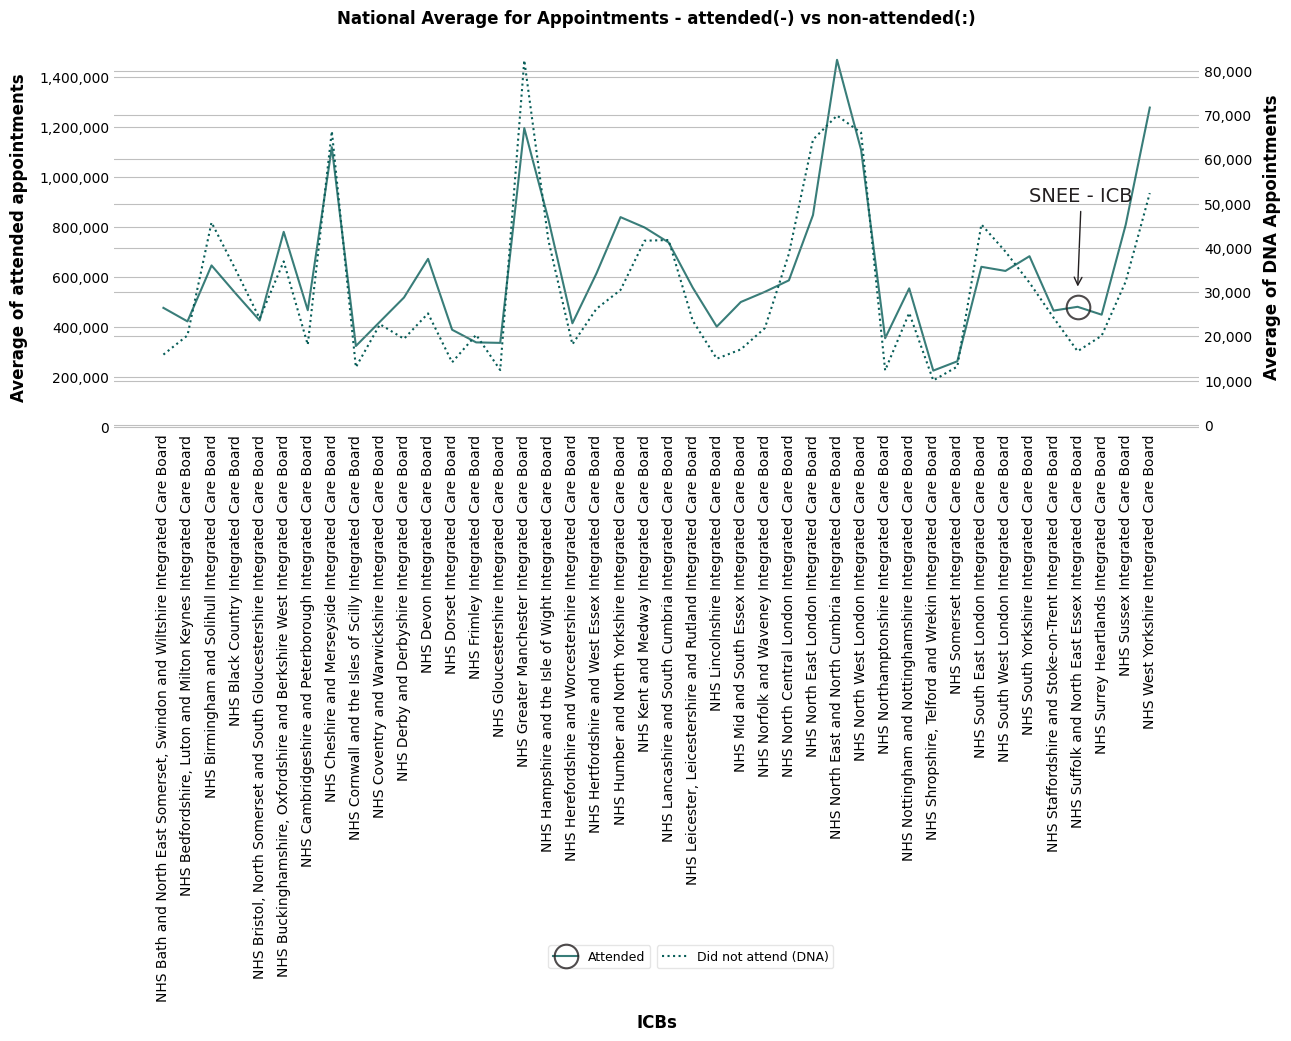

In [70]:
# Convert the 'count_column' to numeric
attended_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(attended_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

# Convert the 'count_column' to numeric
dna_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(dna_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

attended_df_mean2 = attended_df_mean.groupby('ICB_NAME').mean().reset_index()
dna_df_mean2 = dna_df_mean.groupby('ICB_NAME').mean().reset_index()

# Plotting attended vs dna for FY-2022-23-24
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df_mean2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(38,550000), xytext=(36,900000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc =(0.4,-1.4))

# Creating secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average of DNA Appointments')
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean2, linestyle=':', ax=ax2, label ='Did not attend (DNA)')
ax2.legend(loc =(0.5,-1.4))

# Apply the comma-separated format to y-axis of both axes
formatter = FuncFormatter(format_with_commas)
ax.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

# Set y-axis limits to start from 0 only
ax.set_ylim(bottom=-10000) 
ax2.set_ylim(bottom=-1000)

plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)

/tmp/ipykernel_14107/2666140673.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


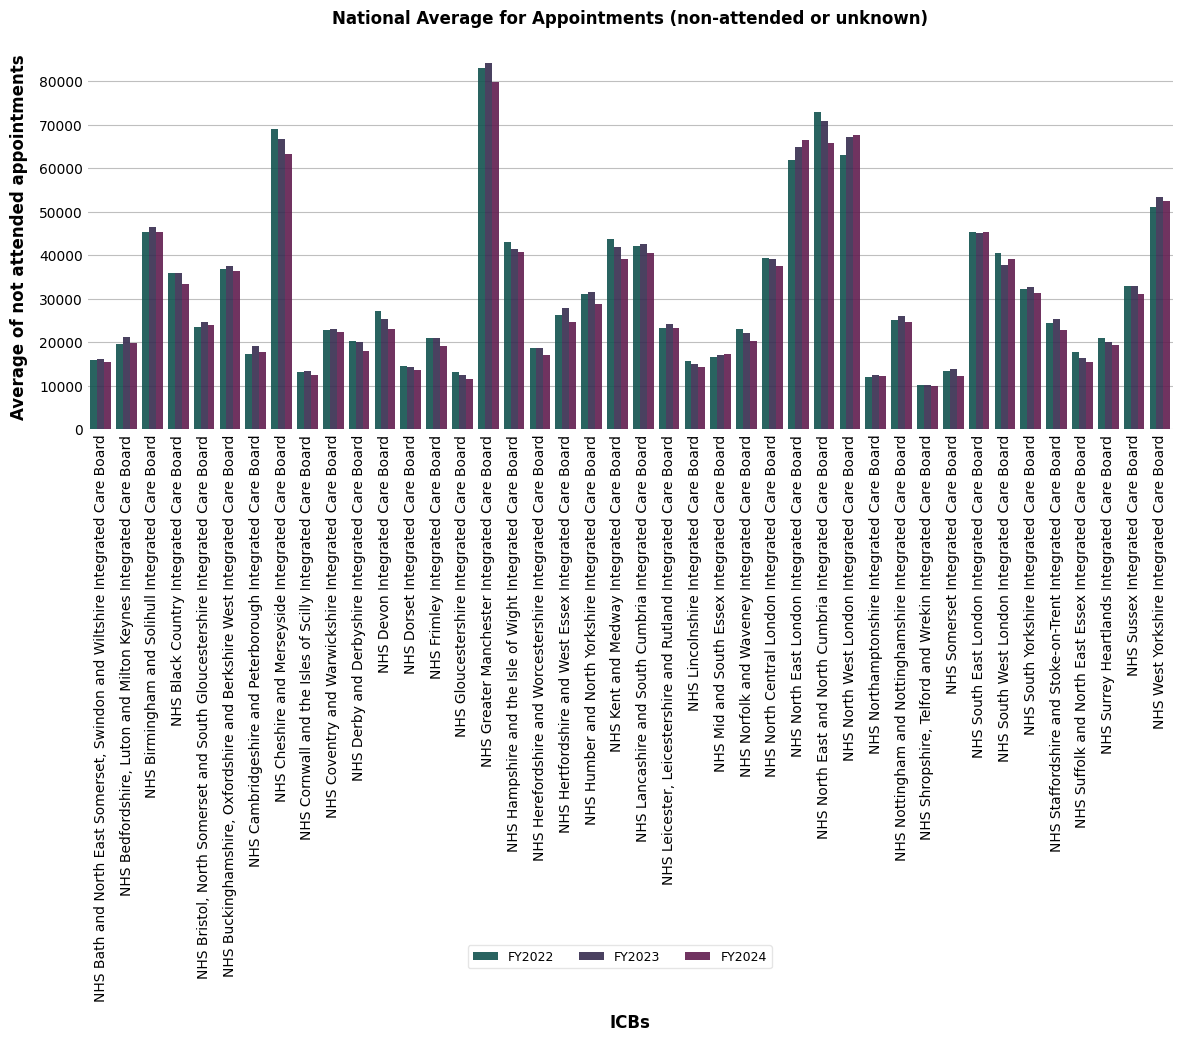

In [71]:
# Plotting did not attended appointments
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=dna_df_mean, hue='FY_YEAR', alpha=0.9)
plt.xlabel('ICBs')
plt.ylabel('Average of not attended appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.legend(loc=(0.35,-1.4), ncol=3)
plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)

### 3.5. Comparing the National average with SNEE

#### 3.5.1. Attended appointments

In [72]:
National_average_attended_2022 = attended_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_attended_2023 = attended_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
National_average_attended_2024_april_august = attended_df_mean.loc[slice(None),'FY2024',:].mean().round(2)
SNEE_average_attended = attended_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

# Rename 'COUNT_OF_APPOINTMENTS' to 'SNEE_COUNT_OF_APPOINTMENTS'
SNEE_average_attended = SNEE_average_attended.rename(columns={
    'COUNT_OF_APPOINTMENTS': 'SNEE_COUNT_OF_APPOINTMENTS'
})

# Create a new column 'National_average'
SNEE_average_attended['National_average'] = [
    National_average_attended_2022.item(),  
    National_average_attended_2023.item(), 
    National_average_attended_2024_april_august.item()  
]
SNEE_average_attended

,SNEE_COUNT_OF_APPOINTMENTS,National_average
FY_YEAR,,
FY2022,465021.9,608099.22
FY2023,481801.2,628297.14
FY2024,493589.8,629348.57


**NOTE -->** The National average for FY2024 only includes appointments data from April to August

#### 3.5.2. Did not Attend appointments (DNA)

In [73]:
National_average_dna_2022 = dna_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_dna_2023 = dna_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
National_average_dna_2024_april_august = dna_df_mean.loc[slice(None),'FY2024',:].mean().round(2)
SNEE_average_DNA = dna_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

# Rename 'COUNT_OF_APPOINTMENTS' to 'SNEE_COUNT_OF_APPOINTMENTS'
SNEE_average_DNA = SNEE_average_DNA.rename(columns={
    'COUNT_OF_APPOINTMENTS': 'SNEE_COUNT_OF_APPOINTMENTS'
})

# Create a new column 'National_average'
SNEE_average_DNA['National_average'] = [
    National_average_dna_2022.item(), 
    National_average_dna_2023.item(), 
    National_average_dna_2024_april_august.item()
]

SNEE_average_DNA

,SNEE_COUNT_OF_APPOINTMENTS,National_average
FY_YEAR,,
FY2022,17822.6,31568.70
FY2023,16479.8,31723.10
FY2024,15572.2,30355.94


**NOTE -->** The National average for FY2024 only includes appointments data from April to August

#### 3.5.3. Unknown Appointments

In [74]:
# Convert the 'count_column' to numeric
unknown_df_mean['COUNT_OF_APPOINTMENTS'] = pd.to_numeric(unknown_df_mean['COUNT_OF_APPOINTMENTS'], errors='coerce')

National_average_unknown_2022 = unknown_df_mean.loc[slice(None),'FY2022',:].mean().round(2)
National_average_unknown_2023 = unknown_df_mean.loc[slice(None),'FY2023',:].mean().round(2)
National_average_unknown_2024_april_august = unknown_df_mean.loc[slice(None),'FY2024',:].mean().round(2)
SNEE_average_unknown = unknown_df_mean.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

# Rename 'COUNT_OF_APPOINTMENTS' to 'SNEE_COUNT_OF_APPOINTMENTS'
SNEE_average_unknown = SNEE_average_unknown.rename(columns={
    'COUNT_OF_APPOINTMENTS': 'SNEE_COUNT_OF_APPOINTMENTS'
})

# Create a new column 'National_average'
SNEE_average_unknown['National_average'] = [
    National_average_unknown_2022.item(),  
    National_average_unknown_2023.item(),  
    National_average_unknown_2024_april_august.item()
]

SNEE_average_unknown

,SNEE_COUNT_OF_APPOINTMENTS,National_average
FY_YEAR,,
FY2022,16936.3,27095.84
FY2023,27284.0,38691.91
FY2024,27752.2,40010.43


**NOTE -->** The National average for FY2024 only includes appointments data from April to August

### 3.6. Mean DNA Appointments by HCP-type and Appointment-mode.

In [75]:
# Dataframe for appointments attended
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)

# Dataframe for appointments DNA
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_CODE','APPT_STATUS','APPOINTMENT_MONTH']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).sum().round(4)


#### 3.6.1. National averages

In [76]:
# Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

# Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

# Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
print('National Averages for DNA appointments based on HCP-type and Appointment mode')
national_average_dna_hcp_appt_type

National Averages for DNA appointments based on HCP-type and Appointment mode


,GP,Practice staff,Unknown
Face to face,206571.7143,548731.7143,999.5429
Home visit,1674.0476,2806.6667,873.1389
Telephone,63258.2857,68889.9048,1922.2571
Unknown,1458.5476,2954.0000,9807.7419
Video/Online,1634.4762,2873.1190,55.4000


#### 3.6.2. SNEE-ICB averages

In [77]:
print('SNEE-ICB Averages for DNA appointments based on HCP-type and Appointment mode')
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:]

SNEE-ICB Averages for DNA appointments based on HCP-type and Appointment mode


COUNT_OF_APPOINTMENTS
HCP_TYPE             APPT_MODE                          
GP                   Face-to-Face                  74657
                     Home Visit                      595
                     Telephone                     13514
                     Unknown                         336
                     Video/Online                    967
Other Practice staff Face-to-Face                 346194
                     Home Visit                     2116
                     Telephone                     18962
                     Unknown                        1395
                     Video/Online                   3895
Unknown              Face-to-Face                  15507
                     Home Visit                      150
                     Telephone                        73
                     Unknown                       11129

#### 3.6.3. Plots

<Axes: >

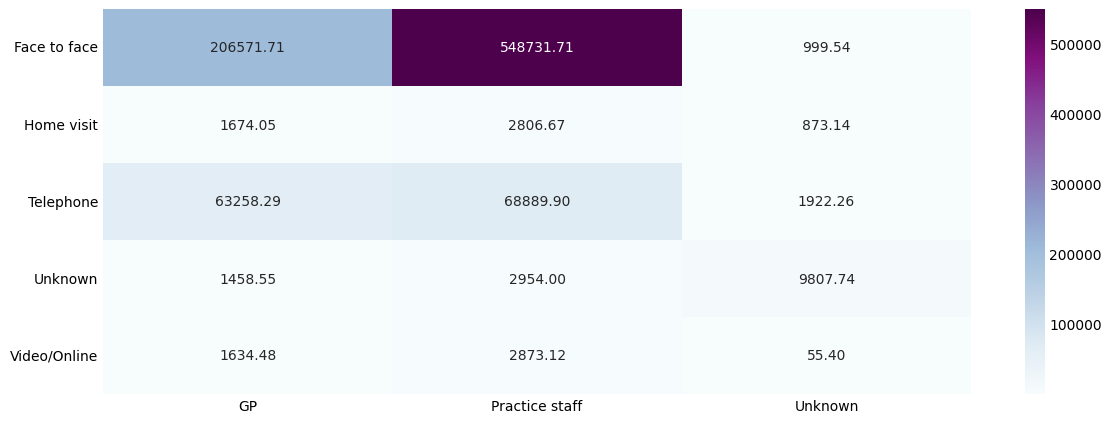

In [78]:
plt.subplots(figsize=(14,5))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

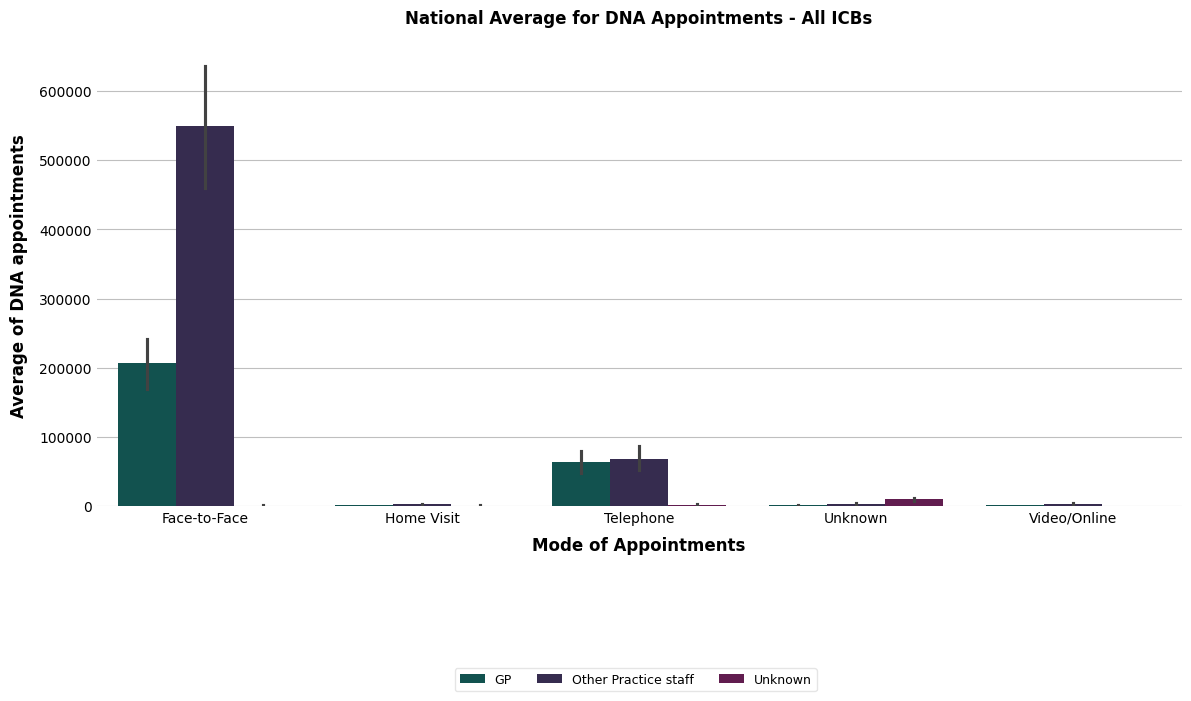

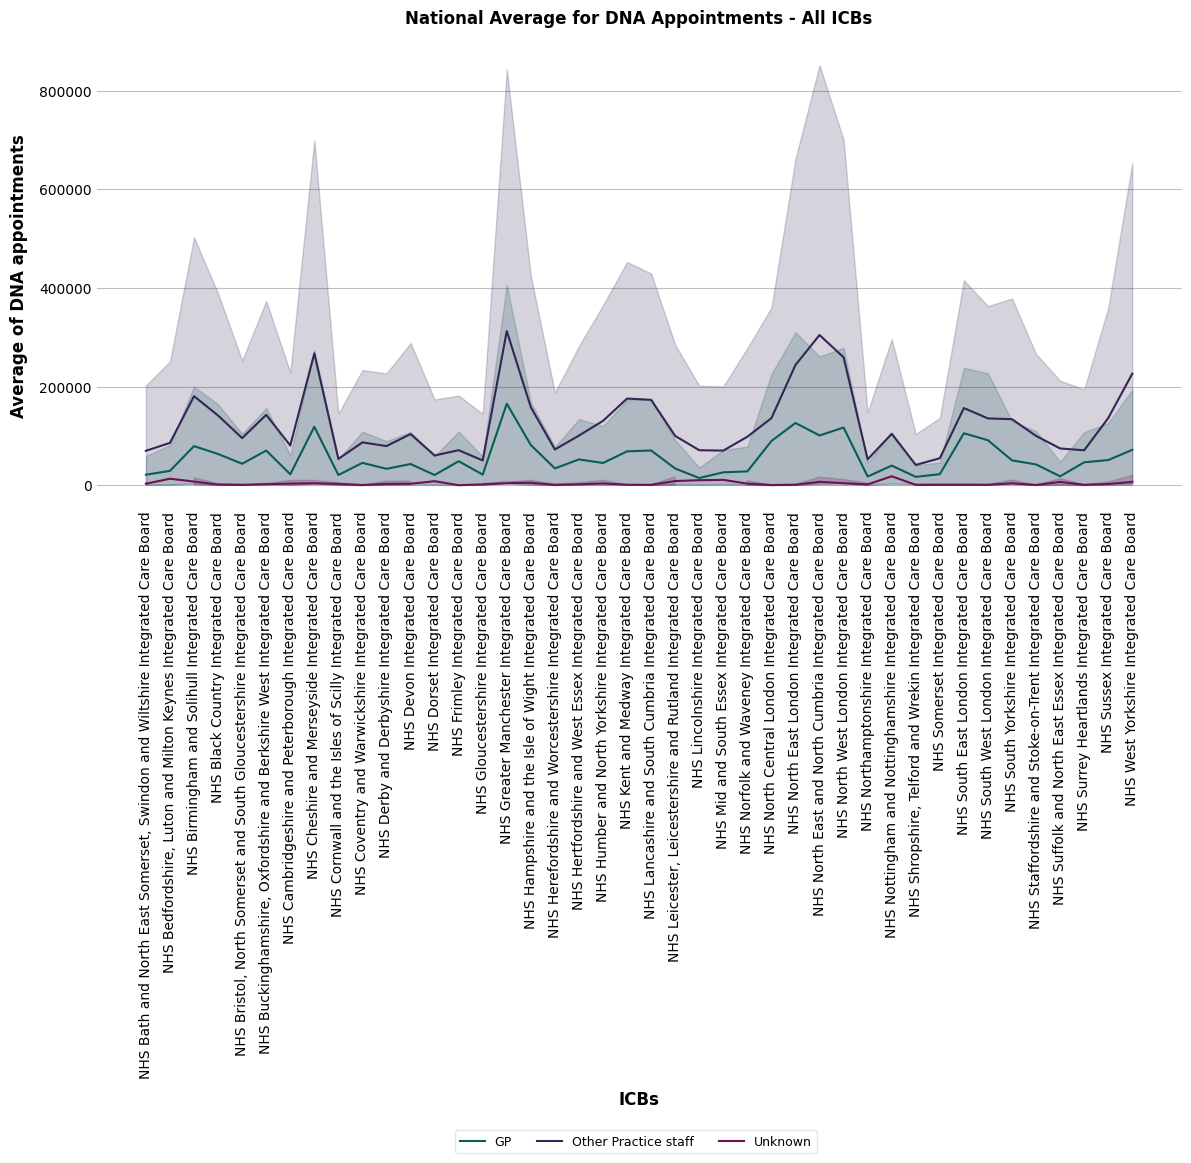

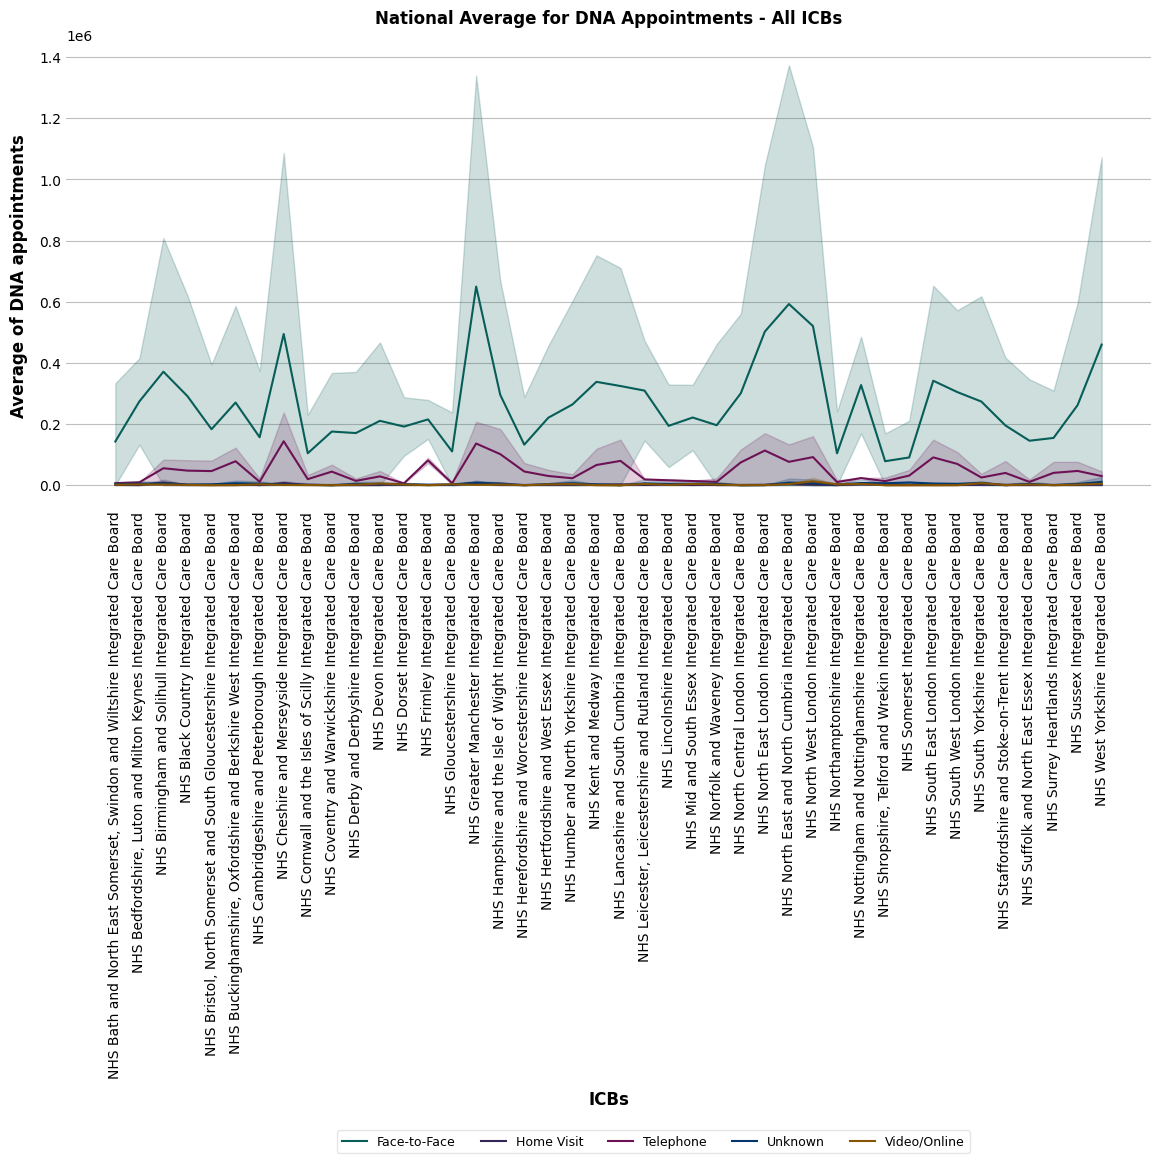

In [79]:
# Plotting the DNA appointments barplot
plt.subplots(figsize=(14,6))
sns.barplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('Mode of Appointments')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.33,-0.4), ncol=3)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.33,-1.4), ncol=3)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.legend(loc=(0.25,-1.4), ncol=5)

## 4. Analysis using proportion(%) of appointments

In [80]:
appt_proportion = combined_df_copy.loc[:,['SUB_ICB_LOCATION_CODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','APPOINTMENT_MONTH']].pivot_table(index=['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion.sum(axis=1)
appt_proportion = appt_proportion.div(sum_row, axis=0)*100
appt_proportion = appt_proportion.reset_index()
appt_proportion.columns = ['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']
appt_proportion.head()

# Converting months into FY-years
appt_proportion['FY_YEAR'] = appt_proportion['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

# Dataframe for appointments DNA
appt_proportion_fy = appt_proportion.drop(columns=['APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','FY_YEAR']).mean().round(2)

### 4.1. Comparing the National proportions with SNEE (based on FY-YEARS)

In [81]:
# Calculate national proportions for each fiscal year
National_proportion_2022 = appt_proportion_fy.loc[slice(None), 'FY2022', :].mean().round(2)
National_proportion_2023 = appt_proportion_fy.loc[slice(None), 'FY2023', :].mean().round(2)
National_proportion_2024_april_august = appt_proportion_fy.loc[slice(None), 'FY2024', :].mean().round(2)

# Select SNEE sub ICB proportions
SNEE_sub_icb_proportion = appt_proportion_fy.loc[SNEE_SUB_ICB, :]

# Create lists for national averages for each fiscal year and category (Attended, DNA, Unknown)
national_averages_attended = []
national_averages_dna = []
national_averages_unknown = []

# Loop over the fiscal years and assign corresponding national averages to the lists
for fy_year in SNEE_sub_icb_proportion.index.get_level_values('FY_YEAR'):
    if fy_year == 'FY2022':
        national_averages_attended.append(National_proportion_2022['Attended'])
        national_averages_dna.append(National_proportion_2022['DNA'])
        national_averages_unknown.append(National_proportion_2022['Unknown'])
    elif fy_year == 'FY2023':
        national_averages_attended.append(National_proportion_2023['Attended'])
        national_averages_dna.append(National_proportion_2023['DNA'])
        national_averages_unknown.append(National_proportion_2023['Unknown'])
    elif fy_year == 'FY2024':
        national_averages_attended.append(National_proportion_2024_april_august['Attended'])
        national_averages_dna.append(National_proportion_2024_april_august['DNA'])
        national_averages_unknown.append(National_proportion_2024_april_august['Unknown'])

# Add the new columns to the DataFrame
SNEE_sub_icb_proportion['National_average_attended'] = national_averages_attended
SNEE_sub_icb_proportion['National_average_dna'] = national_averages_dna
SNEE_sub_icb_proportion['National_average_unknown'] = national_averages_unknown

SNEE_sub_icb_proportion

Attended   DNA  Unknown  \
SUB_ICB_LOCATION_CODE FY_YEAR                            
06L                   FY2022      93.62  2.79     3.59   
                      FY2023      91.44  2.79     5.77   
                      FY2024      92.04  2.50     5.46   
06T                   FY2022      91.16  4.91     3.92   
                      FY2023      90.65  3.85     5.50   
                      FY2024      90.38  3.79     5.83   
07K                   FY2022      94.88  2.84     2.29   
                      FY2023      93.42  2.68     3.90   
                      FY2024      93.67  2.36     3.97   

                               National_average_attended  \
SUB_ICB_LOCATION_CODE FY_YEAR                              
06L                   FY2022                       91.21   
                      FY2023                       90.04   
                      FY2024                       90.06   
06T                   FY2022                       91.21   
                      FY2023                       90.04   
                      FY2024                       90.06   
07K                   FY2022                       91.21   
                      FY2023                       90.04   
                      FY2024                       90.06   

                               National_average_dna  National_average_unknown  
SUB_ICB_LOCATION_CODE FY_YEAR                                                  
06L                   FY2022                   4.63                      4.17  
                      FY2023                   4.45                      5.51  
                      FY2024                   4.22                      5.72  
06T                   FY2022                   4.63                      4.17  
                      FY2023                   4.45                      5.51  
                      FY2024                   4.22                      5.72  
07K                   FY2022                   4.63                      4.17  
                      FY2023                   4.45                      5.51  
                      FY2024                   4.22                      5.72

In [82]:
SNEE_proportion = SNEE_sub_icb_proportion.reset_index().drop(columns=['SUB_ICB_LOCATION_CODE']).groupby(['FY_YEAR']).mean().round(2)
SNEE_proportion

,Attended,DNA,Unknown,National_average_attended,National_average_dna,National_average_unknown
FY_YEAR,,,,,,
FY2022,93.22,3.51,3.27,91.21,4.63,4.17
FY2023,91.84,3.11,5.06,90.04,4.45,5.51
FY2024,92.03,2.88,5.09,90.06,4.22,5.72


### 4.2 Proportion by HCP_TYPE and APPT_MODE

In [83]:
appt_proportion_df = combined_df_copy.loc[:,['ICB_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS']].pivot_table(index=['ICB_NAME','HCP_TYPE','APPT_MODE'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df.sum(axis=1)
appt_proportion_df = appt_proportion_df.div(sum_row, axis=0)*100
appt_proportion_df_imputed = appt_proportion_df.fillna(appt_proportion_df.mean())

In [84]:
# Calculating National average for HCP='GP' for Appointments
GP_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(2)
GP_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'GP','Home Visit'),:].mean().round(2)
GP_tel_ratio = appt_proportion_df_imputed.loc[:,'GP','Telephone'].mean().round(2)
GP_unknown_ratio = appt_proportion_df_imputed.loc[:,'GP','Unknown'].mean().round(2)
GP_video_online_ratio = appt_proportion_df_imputed.loc[:,'GP','Video/Online'].mean().round(2)

# Calculating National average for HCP='Other practice staff' for  Appointments
other_staff_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(2)
other_staff_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(2)
other_staff_tel_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Telephone'].mean().round(2)
other_staff_unknown_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Unknown'].mean().round(2)
other_staff_video_online_ratio = appt_proportion_df_imputed.loc[:,'Other Practice staff','Video/Online'].mean().round(2)

# Calculating National ratio for HCP='unknown' for Appointments
unknown_f2f_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(2)
unknown_homevisit_ratio = appt_proportion_df_imputed.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(2)
unknown_tel_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Telephone'].mean().round(2)
unknown_unknown_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Unknown'].mean().round(2)
unknown_video_online_ratio = appt_proportion_df_imputed.loc[:,'Unknown','Video/Online'].mean().round(2)

#### 4.1.1. Nationally 

In [85]:
res = {
    ('GP','Attended') : [GP_f2f_ratio.iloc[0], GP_homevisit_ratio.iloc[0], GP_tel_ratio.iloc[0], GP_unknown_ratio.iloc[0], GP_video_online_ratio.iloc[0]],
    ('GP','DNA') : [GP_f2f_ratio.iloc[1], GP_homevisit_ratio.iloc[1], GP_tel_ratio.iloc[1], GP_unknown_ratio.iloc[1], GP_video_online_ratio.iloc[1]],
    ('GP','Unknown') : [GP_f2f_ratio.iloc[2], GP_homevisit_ratio.iloc[2], GP_tel_ratio.iloc[2], GP_unknown_ratio.iloc[2], GP_video_online_ratio.iloc[2]],
    ('Other Staff','Attended') : [other_staff_f2f_ratio.iloc[0], other_staff_homevisit_ratio.iloc[0], other_staff_tel_ratio.iloc[0], other_staff_unknown_ratio.iloc[0], other_staff_video_online_ratio.iloc[0]],
    ('Other Staff','DNA') : [other_staff_f2f_ratio.iloc[1], other_staff_homevisit_ratio.iloc[1], other_staff_tel_ratio.iloc[1], other_staff_unknown_ratio.iloc[1], other_staff_video_online_ratio.iloc[1]],
    ('Other Staff','Unknown') : [other_staff_f2f_ratio.iloc[2], other_staff_homevisit_ratio.iloc[2], other_staff_tel_ratio.iloc[2], other_staff_unknown_ratio.iloc[2], other_staff_video_online_ratio.iloc[2]],
    ('Unknown','Attended') : [unknown_f2f_ratio.iloc[0], unknown_homevisit_ratio.iloc[0], unknown_tel_ratio.iloc[0], unknown_unknown_ratio.iloc[0], unknown_video_online_ratio.iloc[0]],
    ('Unknown','DNA') : [unknown_f2f_ratio.iloc[1], unknown_homevisit_ratio.iloc[1], unknown_tel_ratio.iloc[1], unknown_unknown_ratio.iloc[1], unknown_video_online_ratio.iloc[1]],
    ('Unknown','Unknown') : [unknown_f2f_ratio.iloc[2], unknown_homevisit_ratio.iloc[2], unknown_tel_ratio.iloc[2], unknown_unknown_ratio.iloc[2], unknown_video_online_ratio.iloc[2]]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_ratio_dna_hcp_appt_type = pd.DataFrame(res, index=index_values)
national_ratio_dna_hcp_appt_type

GP               Other Staff                Unknown        \
             Attended   DNA Unknown    Attended   DNA Unknown Attended   DNA   
Face to face    93.02  3.61    3.37       87.68  6.99    5.33    75.70  2.29   
Home visit      84.79  2.02   13.20       82.84  3.16   14.01    67.79  3.80   
Telephone       95.14  1.64    3.22       92.03  3.38    4.59    90.15  2.35   
Unknown         50.21  2.15   47.63       41.40  2.94   55.67    74.19  2.27   
Video/Online    89.91  0.80    9.30       89.44  1.39    9.17    79.00  2.73   

                      
             Unknown  
Face to face   24.33  
Home visit     30.63  
Telephone      10.79  
Unknown        31.84  
Video/Online   21.19

#### 5.1.2. SNEE-ICB 

In [86]:
appt_proportion_df_imputed.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:].round(2)

COUNT_OF_APPOINTMENTS               
APPT_STATUS                                    Attended    DNA Unknown
HCP_TYPE             APPT_MODE                                        
GP                   Face-to-Face                 94.93   2.21    2.86
                     Home Visit                   94.10   1.48    4.42
                     Telephone                    97.31   0.65    2.04
                     Unknown                      54.27   2.32   43.41
                     Video/Online                 93.06   0.88    6.06
Other Practice staff Face-to-Face                 89.53   4.95    5.52
                     Home Visit                   89.38   3.22    7.40
                     Telephone                    95.14   1.20    3.66
                     Unknown                      47.27   3.10   49.63
                     Video/Online                 93.37   2.87    3.76
Unknown              Face-to-Face                 41.70  49.28    9.02
                     Home Visit                   89.15   0.92    9.93
                     Telephone                    93.40   3.82    2.77
                     Unknown                      90.67   2.26    7.06
                     Video/Online                100.00   2.76   18.84

## 6. Visualizations 

In [87]:
appt_proportion_df_plots = combined_df_copy.pivot_table(index=['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df_plots.sum(axis=1)
appt_proportion_df_plots = appt_proportion_df_plots.div(sum_row, axis=0)*100
appt_proportion_df_plots = appt_proportion_df_plots.reset_index().round(2)
appt_proportion_df_plots.columns = ['ICB_NAME','SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','APPOINTMENT_MONTH','Attended','DNA','Unknown']

# Converting months into FY-years
appt_proportion_df_plots['FY_YEAR'] = appt_proportion_df_plots['APPOINTMENT_MONTH'].map(lambda x: f"FY{convert_to_fy(x)}")

### 6.1. Attended Appointments

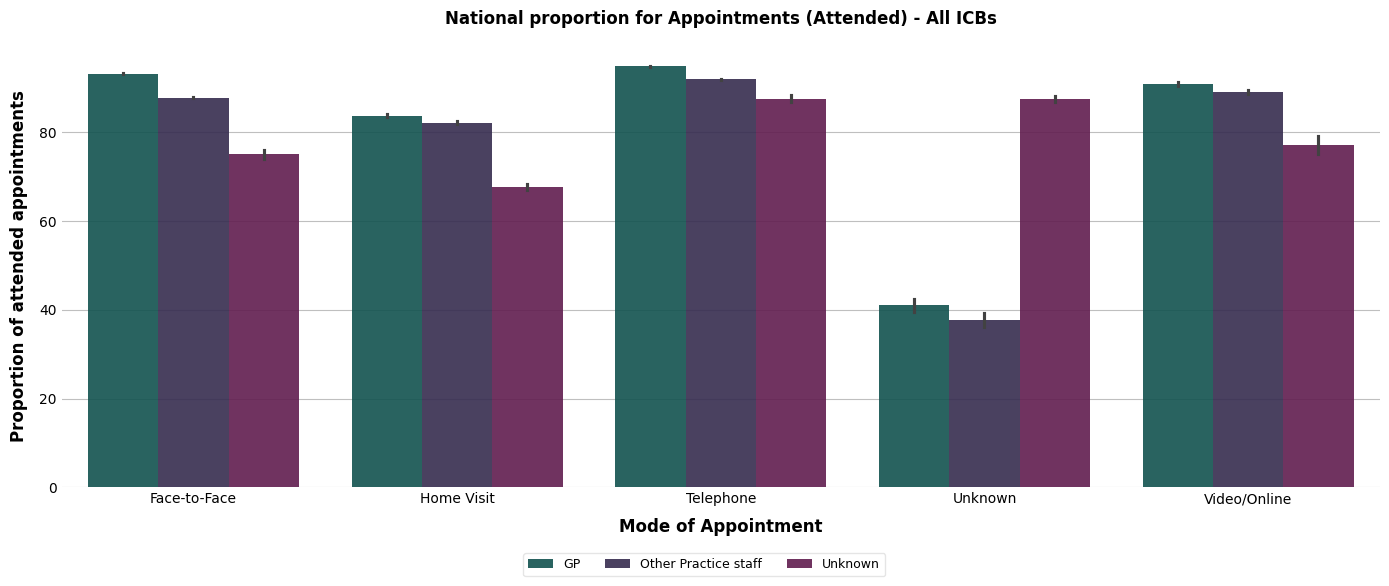

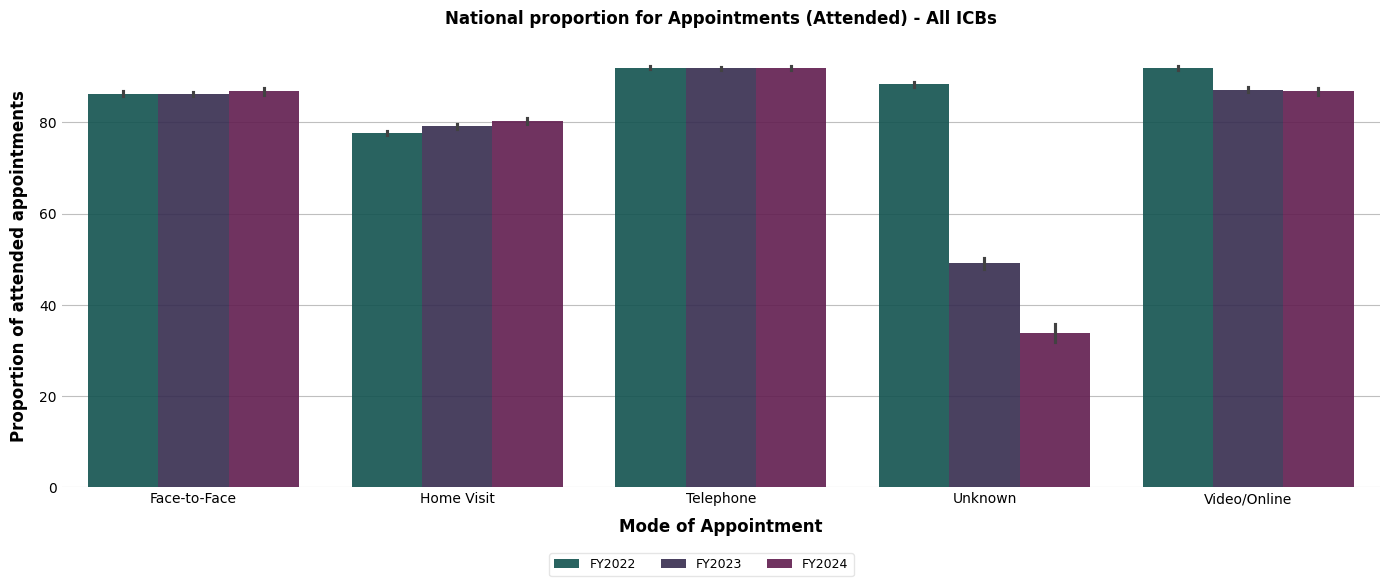

In [88]:
# Plotting the Attended appointments by HCP type
plt.subplots(figsize=(14,6))
sns.barplot(x='APPT_MODE', y='Attended', hue='HCP_TYPE',  data=appt_proportion_df_plots, alpha=0.9)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.legend(loc=(0.35,-0.2), ncol=3)
plt.tight_layout()
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the Attended appointments by FY Years
plt.subplots(figsize=(14,6))
sns.barplot(x='APPT_MODE', y='Attended', hue='FY_YEAR',  data=appt_proportion_df_plots, alpha=0.9)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.tight_layout()
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)

### 6.2. Did not Attend appointments (DNA) 

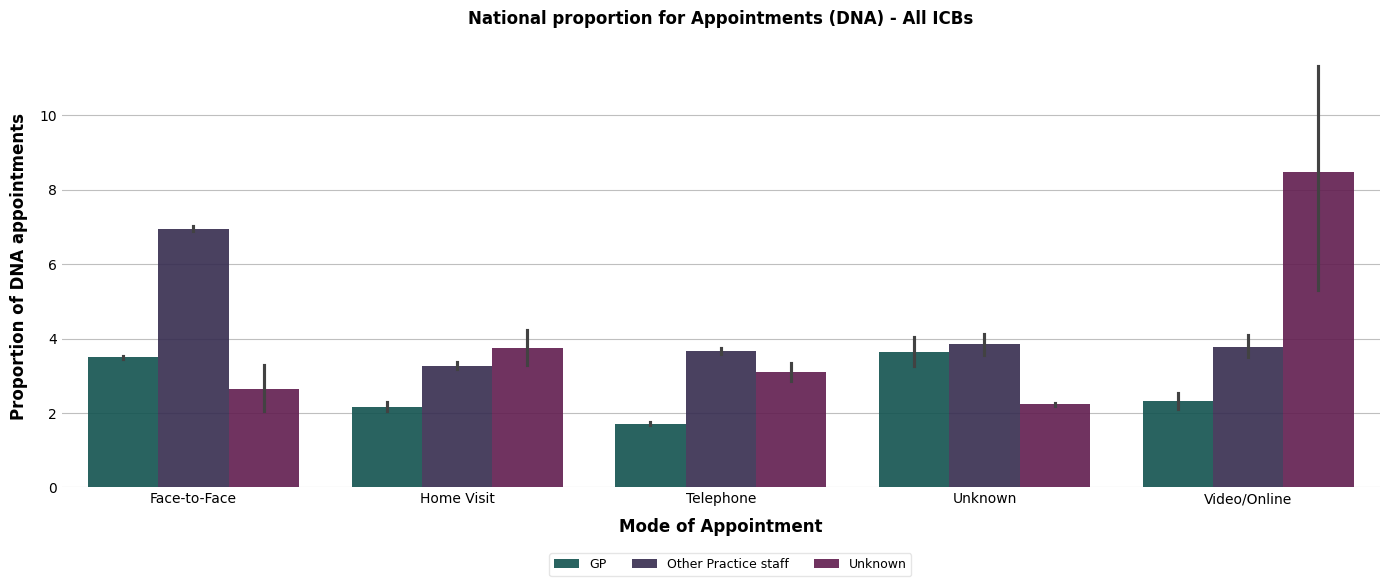

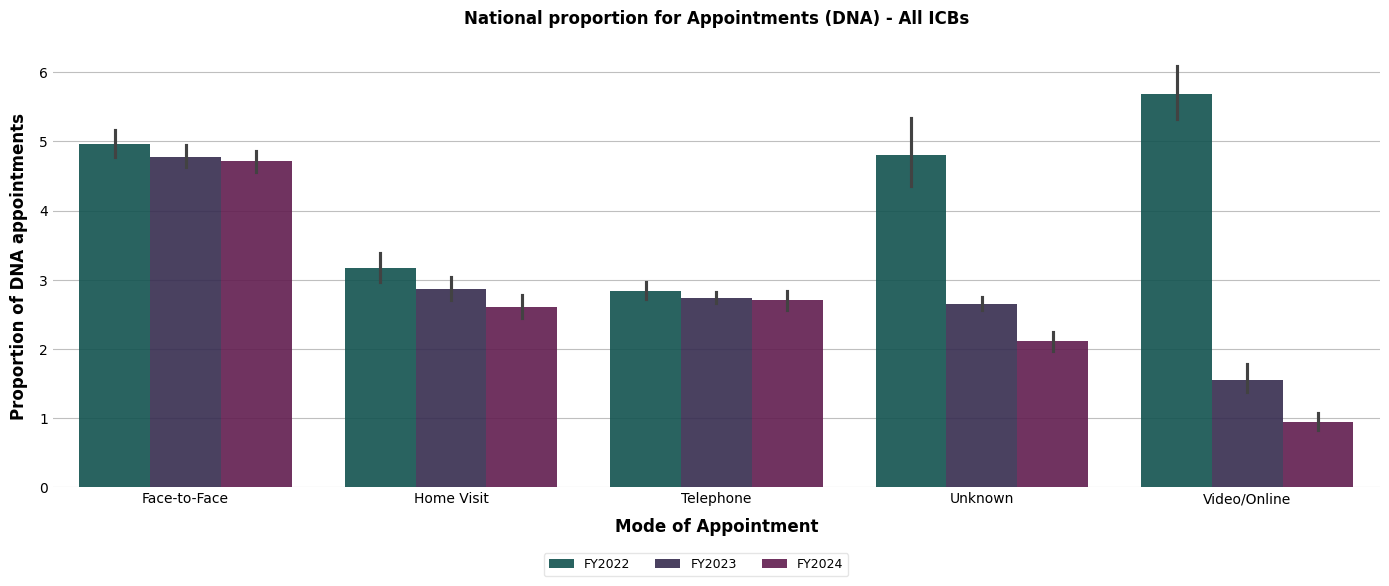

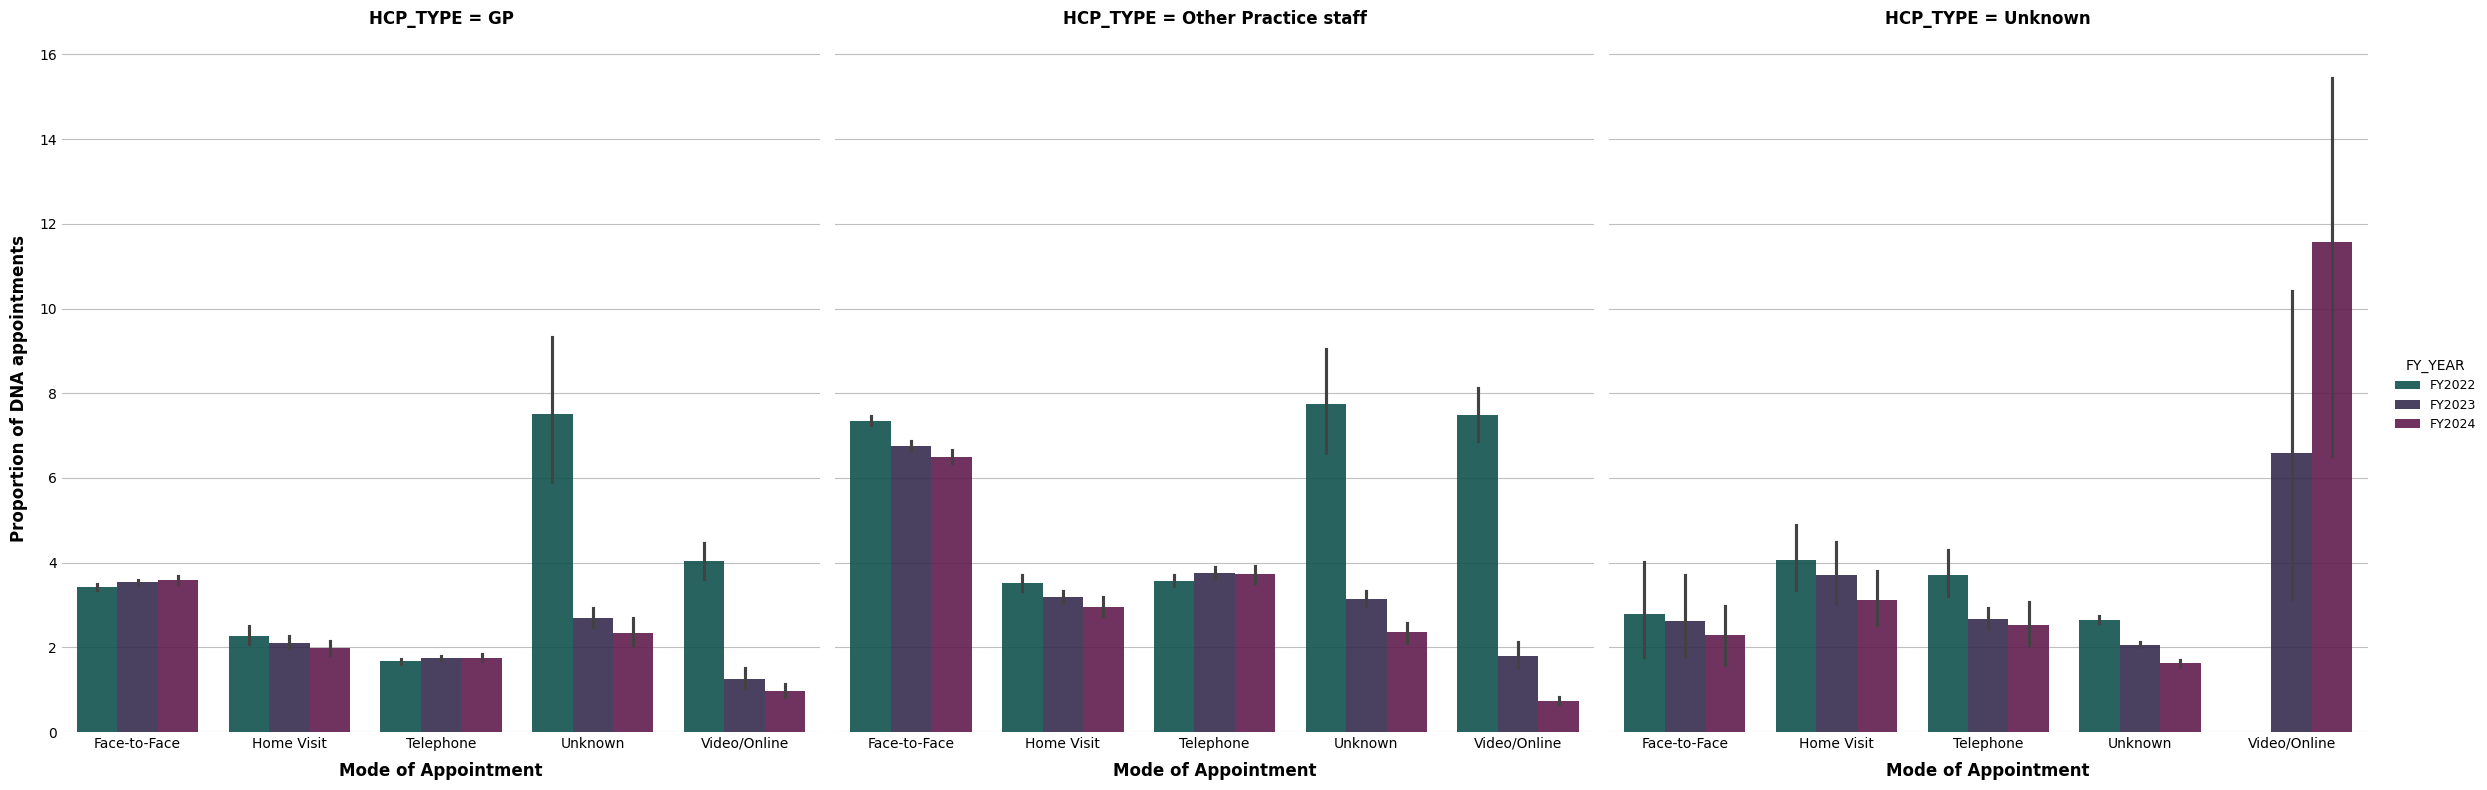

In [89]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(14,6))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots, alpha=0.9)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.tight_layout()
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(14,6))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots, alpha=0.9)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.2), ncol=3)
plt.tight_layout()
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)


# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='HCP_TYPE' , kind='bar', data=appt_proportion_df_plots, alpha=0.9, height=8)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

### 6.3. SNEE-ICB Analysis

In [90]:
snee_appt_proportion_df = appt_proportion_df_plots.loc[appt_proportion_df_plots['SUB_ICB_LOCATION_CODE'].isin(SNEE_SUB_ICB)]
snee_appt_proportion_df = snee_appt_proportion_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE','FY_YEAR']).mean()


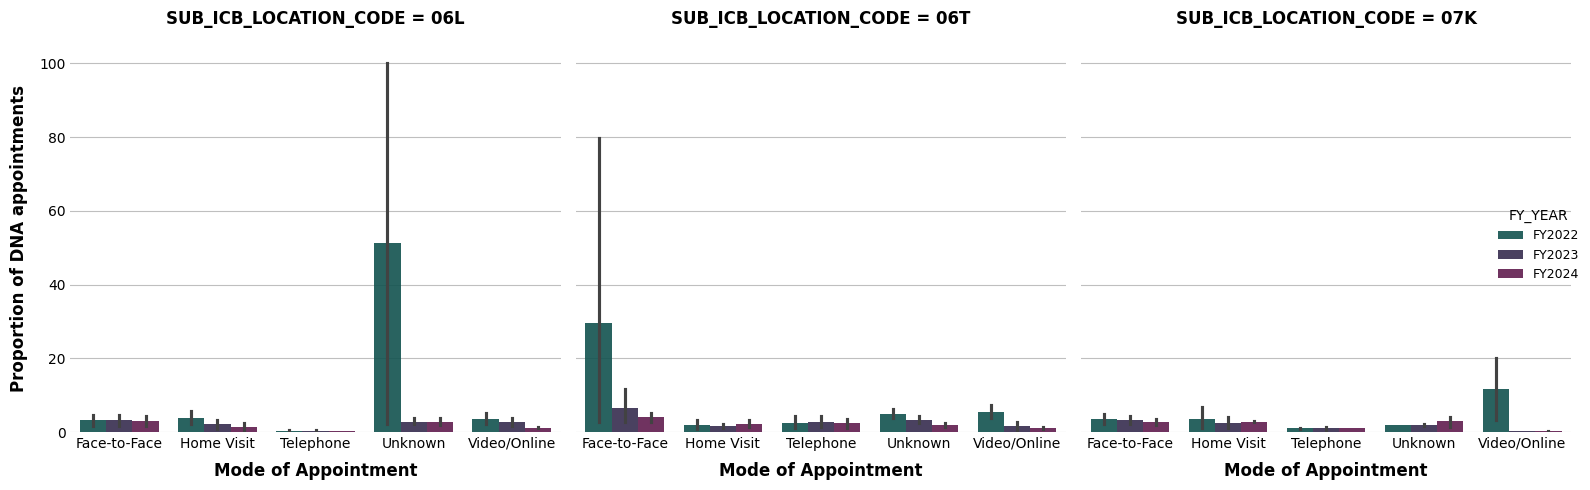

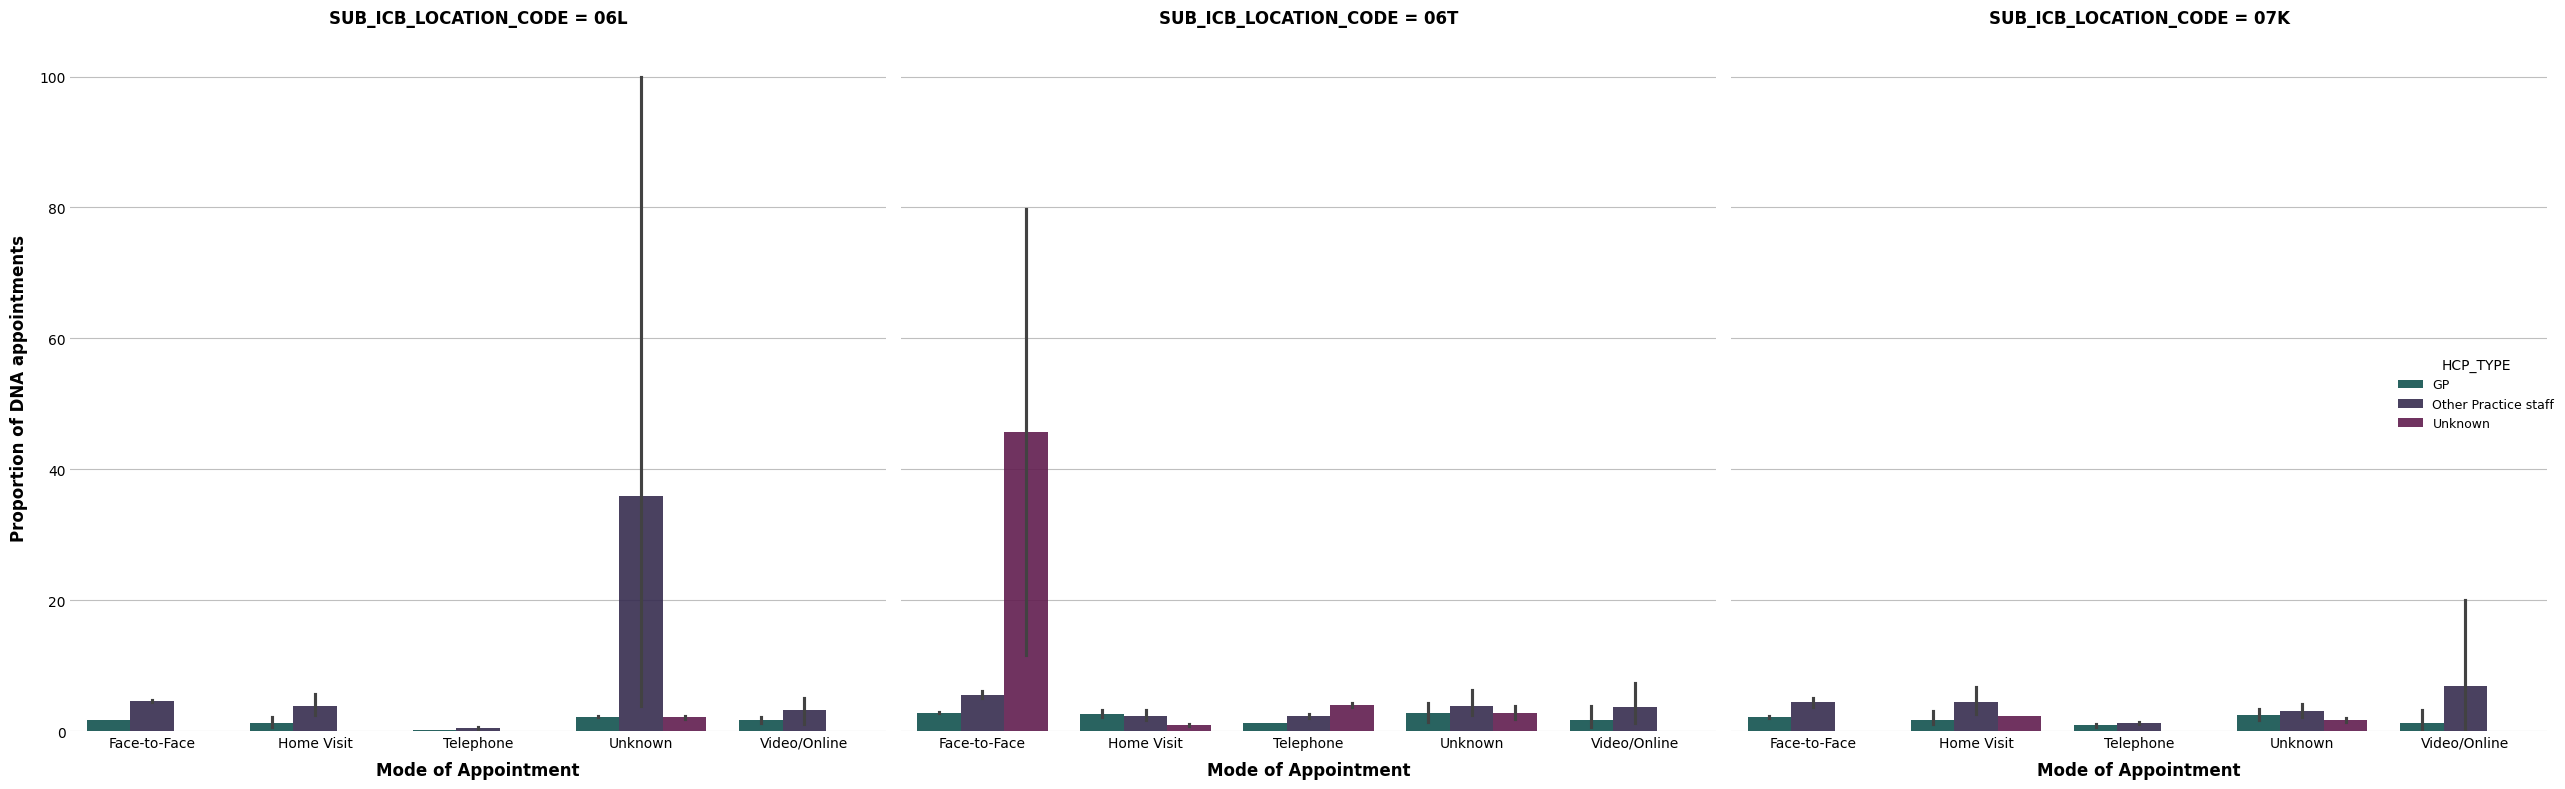

In [91]:
# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df, alpha=0.9)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.tight_layout()
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE', col='SUB_ICB_LOCATION_CODE' , kind='bar', data=snee_appt_proportion_df, alpha=0.9, height=8)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.tight_layout()
plt.savefig(f'{plot_counter.plot_name}.png', dpi=300)
plt.show()

## 7. Correlation matrix (SNEE sub-icb's)

In [92]:
snee_appt_proportion_df = snee_appt_proportion_df.reset_index()

cols = ['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']

# Convert categorical columns to one-hot encoded features
ce_OHE = pd.get_dummies(snee_appt_proportion_df[cols])

dna_correlations_snee_icbs = ce_OHE.corrwith(snee_appt_proportion_df['DNA']).sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_snee_icbs)

APPT_MODE_Face-to-Face           0.133321
APPT_MODE_Unknown                0.112205
HCP_TYPE_Other Practice staff    0.099106
HCP_TYPE_Unknown                 0.096461
SUB_ICB_LOCATION_CODE_06L        0.050065
SUB_ICB_LOCATION_CODE_06T        0.039058
APPT_MODE_Video/Online          -0.047138
APPT_MODE_Home Visit            -0.082667
SUB_ICB_LOCATION_CODE_07K       -0.090500
APPT_MODE_Telephone             -0.117008
HCP_TYPE_GP                     -0.175618
dtype: float64


## 8. Inferences and Results

### 8.1. Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

In [93]:
SNEE_average_DNA

,SNEE_COUNT_OF_APPOINTMENTS,National_average
FY_YEAR,,
FY2022,17822.6,31568.70
FY2023,16479.8,31723.10
FY2024,15572.2,30355.94


- We can see that the each year's average for non-attended appointments for SNEE-ICB is much lesser than National Average.

### 8.2. Are the missed appointments proportion (%) consistent over time using multiple years?

- The missed appointments are consistent over years when appointment mode is Face to Face, home visit or telephonic
- The missed appointments are not consistent over years when appointment mode is UNknown or Video/ONline

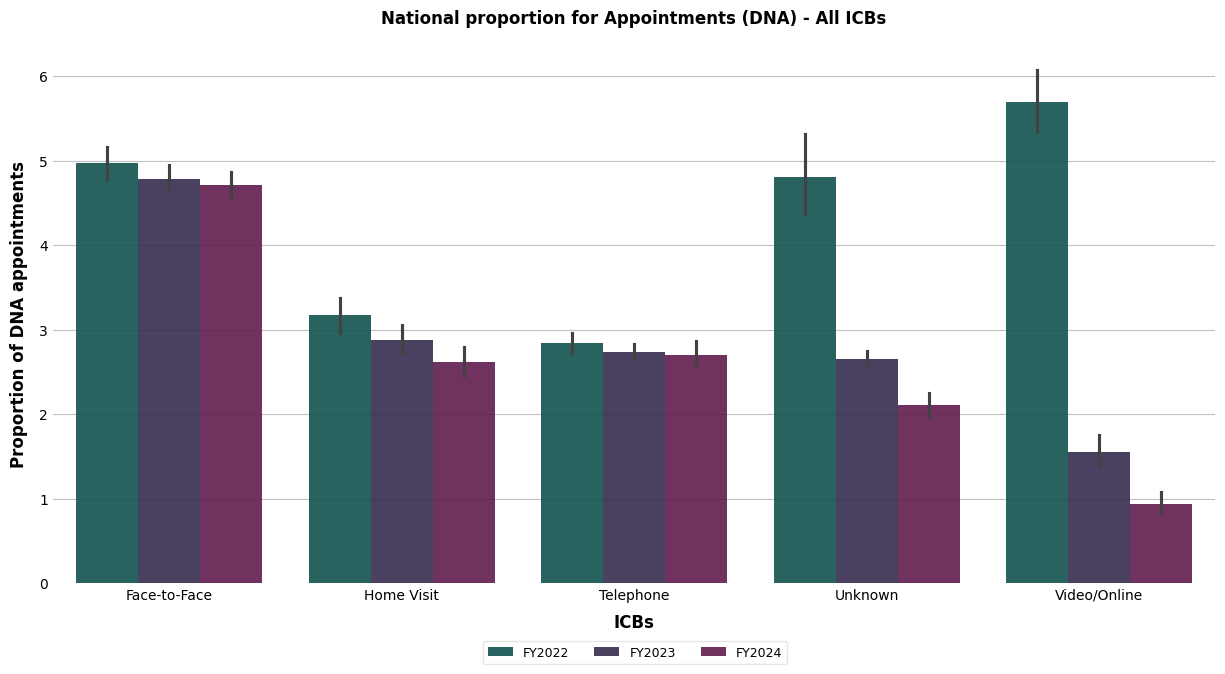

In [94]:
# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df_plots, alpha=0.9)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.37,-0.15), ncol=3)

### 8.3. Across staff groups & Sub-ICB, are some appointments more likely to be missed?


- Appointments that are with 'other practice staff' are most likely to be missed specially when mode of appointments is Face to Face, followed by UNknown

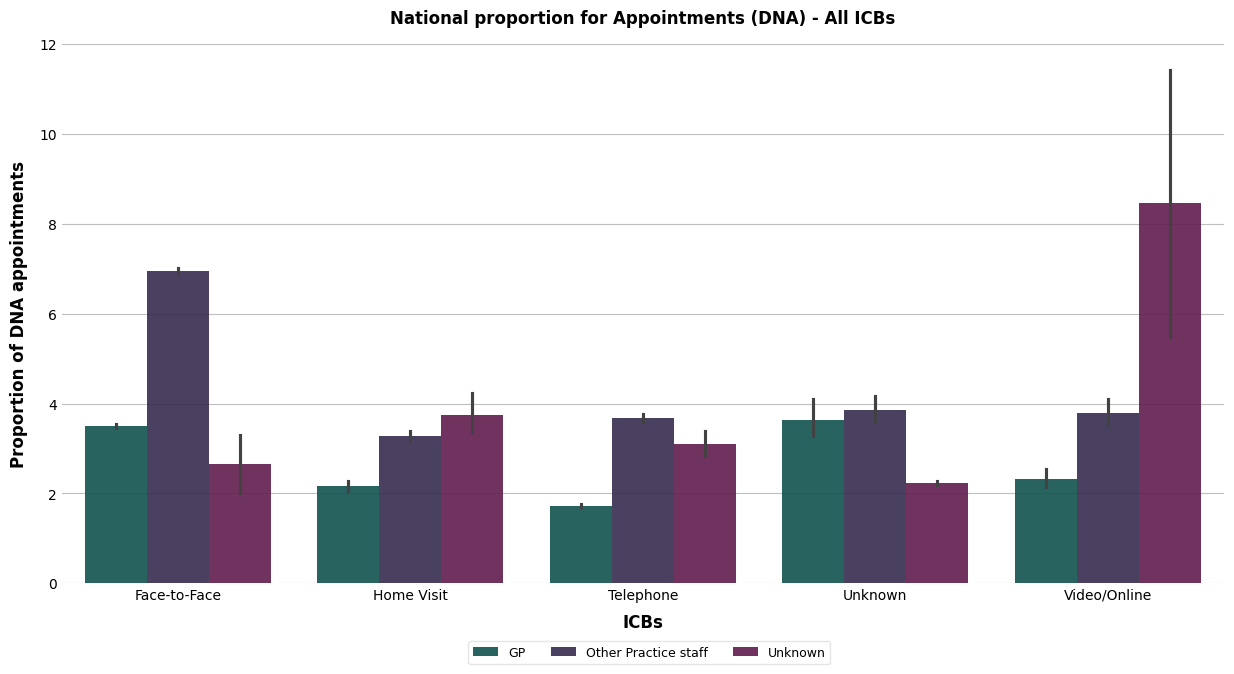

In [95]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df_plots, alpha=0.9)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.legend(loc=(0.35,-0.15), ncol=3)
plt.show()

### 8.4. What is the mean likelihood that someone  Will not attend? from a combination of Sub-ICB, Staff type, Appointment type. 
### 8.5. to determine if a patient with the above appointment will attend.

####  **For SNEE-ICB**

In [96]:
dna_correlations_snee_icbs

APPT_MODE_Face-to-Face           0.133321
APPT_MODE_Unknown                0.112205
HCP_TYPE_Other Practice staff    0.099106
HCP_TYPE_Unknown                 0.096461
SUB_ICB_LOCATION_CODE_06L        0.050065
SUB_ICB_LOCATION_CODE_06T        0.039058
APPT_MODE_Video/Online          -0.047138
APPT_MODE_Home Visit            -0.082667
SUB_ICB_LOCATION_CODE_07K       -0.090500
APPT_MODE_Telephone             -0.117008
HCP_TYPE_GP                     -0.175618
dtype: float64

- From the above Correlation matrix, we can infer the likelihood that a person in SNEE area will not attend (dna) appointment.
- Positive Correlation - if Appointment_MODE = 'Face-to-face' and HCP_TYPE = 'Unknown', then the person is most likely to **NOT ATTEND**
- Negative correlation - if HCP_TYPE = 'GP', then the person is most likely to **Attend**
- Interesting to note that if a person belongs to sub-icb North East Essex then its likely to not attend but the correlation is not very strong, so we cannot be very sure. Same goes for west suffolk but in a negative way (person is likely to attend) but again the correlation is not very strong

#### **For all ICB'S(102)**

In [97]:
# Select categorical columns
categorical_columns = ['ICB_NAME','HCP_TYPE', 'APPT_MODE']

# Convert categorical columns to one-hot encoded features
one_hot_encoded = pd.get_dummies(appt_proportion_df_plots[categorical_columns])

dna_correlations_all_sub_icbs = one_hot_encoded.corrwith(appt_proportion_df_plots['DNA']).sort_values(ascending=False)

with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

HCP_TYPE_Other Practice staff                                                             0.179091
APPT_MODE_Face-to-Face                                                                    0.168782
ICB_NAME_NHS Birmingham and Solihull Integrated Care Board                                0.110804
ICB_NAME_NHS Greater Manchester Integrated Care Board                                     0.052656
ICB_NAME_NHS Black Country Integrated Care Board                                          0.031716
ICB_NAME_NHS Staffordshire and Stoke-on-Trent Integrated Care Board                       0.021843
ICB_NAME_NHS Cheshire and Merseyside Integrated Care Board                                0.020665
ICB_NAME_NHS South East London Integrated Care Board                                      0.020422
ICB_NAME_NHS North West London Integrated Care Board                                      0.016469
ICB_NAME_NHS Suffolk and North East Essex Integrated Care Board                           0.016260
ICB_NAME_N

- In all the sub-icb's we can infer from above correlations that if HCP-TYPE = (2 OR Other Practice staff), Then its most likely by someone to not attend the appointment

### 8.6. Persist the distribution information from 8.5. to a yaml file.

In [98]:
years_to_keep = ['FY2023', 'FY2024']

filtered_df = appt_proportion_df_plots[appt_proportion_df_plots['FY_YEAR'].isin(years_to_keep)]

filtered_df = filtered_df.drop(columns=['ICB_NAME','APPOINTMENT_MONTH','FY_YEAR','Unknown','Attended']).groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']).mean().round(2)
filtered_df = filtered_df.fillna(filtered_df.mean()).div(100).round(4)
filtered_df

DNA
SUB_ICB_LOCATION_CODE HCP_TYPE             APPT_MODE           
00L                   GP                   Face-to-Face  0.0232
                                           Home Visit    0.0153
                                           Telephone     0.0096
                                           Unknown       0.0418
                                           Video/Online  0.0129
...                                                         ...
X2C4Y                 Other Practice staff Telephone     0.0087
                                           Unknown       0.0430
                                           Video/Online  0.0041
                      Unknown              Face-to-Face  0.0291
                                           Unknown       0.0238

[1476 rows x 1 columns]

In [99]:
# Converting to Dictionary
dna_proportion_dict = filtered_df.squeeze().to_dict()

In [100]:
# To get the desired format in dictionary - {"ICB_code":  {"GP" {"In person" : 0.04 , "Online": 0.02, "Telephone", . . .}, . . .}, . . .}
nested_dna_proportion_dict = {}

for key, value in dna_proportion_dict.items():
    sub_icb_code, hcp_type, appt_mode = key
    if sub_icb_code not in nested_dna_proportion_dict:
        nested_dna_proportion_dict[sub_icb_code] = {}
    if hcp_type not in nested_dna_proportion_dict[sub_icb_code]:
        nested_dna_proportion_dict[sub_icb_code][hcp_type] = {}
    nested_dna_proportion_dict[sub_icb_code][hcp_type][appt_mode] = value
    
nested_dna_proportion_dict

{'00L': {'GP': {'Face-to-Face': 0.0232,
   'Home Visit': 0.0153,
   'Telephone': 0.0096,
   'Unknown': 0.0418,
   'Video/Online': 0.0129},
  'Other Practice staff': {'Face-to-Face': 0.0587,
   'Home Visit': 0.0177,
   'Telephone': 0.0254,
   'Unknown': 0.0393,
   'Video/Online': 0.023},
  'Unknown': {'Face-to-Face': 0.0291,
   'Home Visit': 0.008,
   'Telephone': 0.0291,
   'Unknown': 0.02}},
 '00N': {'GP': {'Face-to-Face': 0.032,
   'Home Visit': 0.0231,
   'Telephone': 0.0247,
   'Unknown': 0.0034,
   'Video/Online': 0.0323},
  'Other Practice staff': {'Face-to-Face': 0.0605,
   'Home Visit': 0.0354,
   'Telephone': 0.0456,
   'Unknown': 0.0291,
   'Video/Online': 0.0029},
  'Unknown': {'Face-to-Face': 0.0012,
   'Home Visit': 0.0713,
   'Telephone': 0.03,
   'Video/Online': 0.0291}},
 '00P': {'GP': {'Face-to-Face': 0.0447,
   'Home Visit': 0.0172,
   'Telephone': 0.0201,
   'Unknown': 0.013,
   'Video/Online': 0.0005},
  'Other Practice staff': {'Face-to-Face': 0.0734,
   'Home Visi

In [101]:
OUTPUT_YAML_FILE = "outputs/assumptions/dna_appointments.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_dna_proportion_dict, yaml_file)

## Appointment Modes

In [102]:
# add financial year column
combined_df['FY'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH']).map(lambda x: f"FY{convert_to_fy(x)}")
fy_2023_appointments = combined_df.loc[combined_df['FY']=='FY2023'].groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE','APPT_MODE']).sum(numeric_only=True)
hcp_choice_df = round(fy_2023_appointments / fy_2023_appointments.reset_index().groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE']).sum(numeric_only=True),3)

nested_appointment_dict = {}

for key, value in hcp_choice_df.squeeze().to_dict().items():
    sub_icb_code, hcp_type, appt_mode = key
    if sub_icb_code not in nested_appointment_dict:
        nested_appointment_dict[sub_icb_code] = {}
    if hcp_type not in nested_appointment_dict[sub_icb_code]:
        nested_appointment_dict[sub_icb_code][hcp_type] = {}
    nested_appointment_dict[sub_icb_code][hcp_type][appt_mode] = value
    
nested_appointment_dict

OUTPUT_YAML_FILE = "outputs/assumptions/appointment_modes.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_appointment_dict, yaml_file)

/tmp/ipykernel_14107/754323870.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['FY'] = pd.to_datetime(combined_df['APPOINTMENT_MONTH']).map(lambda x: f"FY{convert_to_fy(x)}")


## Staff type

In [103]:

fy_2023_staff = combined_df.loc[combined_df['FY']=='FY2023'].groupby(['SUB_ICB_LOCATION_CODE','HCP_TYPE',]).sum(numeric_only=True)
hcp_person_df = round(fy_2023_staff / fy_2023_staff.reset_index().groupby(['SUB_ICB_LOCATION_CODE']).sum(numeric_only=True),4)

In [104]:
nested_staff_dict = {}

for key, value in hcp_person_df.squeeze().to_dict().items():
    sub_icb_code, hcp_type = key
    if sub_icb_code not in nested_staff_dict:
        nested_staff_dict[sub_icb_code] = {}
    if hcp_type not in nested_staff_dict[sub_icb_code]:
        nested_staff_dict[sub_icb_code][hcp_type] = value
    


OUTPUT_YAML_FILE = "outputs/assumptions/staff_propensity.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_staff_dict, yaml_file)